# Kalman filter tutorial

This python notebook will go over implementing a Kalman filter for data assimilation in a numerically simple physical system. The system we'll consider is a three-mass-spring-oscillator:

<p align="center">
<img src="./images/mass_spring_sketch.jpg" width="500" />
</p>

This will give a ton of options for experimenting with data assimilation as there are many coupled variables/tunable parameters/etc. to consider. The equations of motion are given by:
$$
\begin{align*}
    &m \frac{d^2 \xi_1}{dt^2} + k \xi_1 + k(\xi_1 - \xi_2) + r \frac{d\xi_1 }{dt} = q_1(t)  \\
    &m \frac{d^2 \xi_2}{dt^2} + k\xi_2 + k(\xi_2 - \xi_1) + k (\xi_2 - \xi_3) + r \frac{d\xi_2}{dt} = q_2(t) \\ 
    &m \frac{d^2 \xi_3}{dt^2} + k \xi_3 + k(\xi_3 - \xi_2) + r \frac{d \xi_3}{dt} = q_3(t)
\end{align*}
$$
The position of each mass is denoted with $\xi_k(t)$, and the various parameters are defined as:
$$
\begin{align*}
    &m: \; \; \; \text{Mass of the oscillators (here we assume they all have the same mass)}\\
    &k: \; \; \; \text{Spring coefficient (again assuming all springs have the same coefficient)} \\ 
    &r: \; \; \; \text{Rayleigh friction coefficient} \\
    &\mathbf{q}(t): \; \; \; \text{Forcing vector}
\end{align*}
$$

## Kalman filter equations

In order to write the time-evolution of the above system as $\mathbf{x}(t + \Delta t) = \mathbf{A} \mathbf{x}(t) + \mathbf{B} \mathbf{q}(t) + \mathbf{\Gamma} \mathbf{u}(t)$ we introduce the state vector 
$$
\begin{pmatrix}
    \xi_1 \\ 
    \xi_2 \\ 
    \xi_3 \\ 
    d\xi_1/dt \\ 
    d\xi_2/dt \\
    d\xi_3/dt 
\end{pmatrix}
$$
Upon discretizing in time this defines the state transition matrix
$$
\mathbf{A} = \begin{pmatrix}
        1 & 0 & 0 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 & \Delta t & 0 \\ 0 & 0 & 1 & 0 & 0 & \Delta t \\ -2k\Delta t & k\Delta t & 0 & 1-r\Delta t & 0 & 0 \\ k\Delta t & -3k\Delta t & k\Delta t & 0 & 1-r\Delta t & 0 \\ 0 & k\Delta t & -2k\Delta  & 0 & 0 & 1-r\Delta t
    \end{pmatrix}
$$
The remainder of the terms, $\mathbf{B}, \mathbf{q}, \mathbf{\Gamma},$ and $\mathbf{u}$ will be defined in the code. In general though these represent:
$$
\begin{align*}
&\mathbf{B}: \; \; \; \text{Known forcing distribution matrix} \\
&\mathbf{\Gamma}: \; \; \; \text{Unknown forcing distribution matrix} \\
&\mathbf{u}: \; \; \; \text{Unknown forcing}.
\end{align*}
$$
We then have the full set of Kalman filter equations: 
$$
\begin{align}
&\tilde{\mathbf{x}}(t, -) = \mathbf{A} \tilde{\mathbf{x}}(t-\Delta t) + \mathbf{B} \mathbf{q}(t-\Delta t)\\
&\mathbf{P}(t, -) = \mathbf{A} \mathbf{P} \mathbf{A}^T + \mathbf{\Gamma} \mathbf{Q} \mathbf{\Gamma}^T\\
&\mathbf{K}(t) = \mathbf{P}(t, -) \mathbf{E}^T \left(\mathbf{E} \mathbf{P}(t, -) \mathbf{E}^T + \mathbf{R} \right)^{-1}\\
&\tilde{\mathbf{x}}(t) = \tilde{\mathbf{x}}(t, -) + \mathbf{K}(t) \left(\mathbf{y}(t) - \mathbf{E}\tilde{\mathbf{x}}(t, -) \right)\\
&\mathbf{P}(t) = \mathbf{P}(t, -) - \mathbf{K}(t) \mathbf{E} \mathbf{P}(t, -)
\end{align}
$$
Letting $\langle \cdot \rangle$ denote the expectation value, we have
$$
\begin{align*}
&\langle \mathbf{n}(t) \rangle = \langle \mathbf{u}(t) \rangle = 0 \\
&\langle \mathbf{n}(t) \mathbf{n}(t)^T \rangle = \mathbf{R}(t) \\ 
&\langle \mathbf{u}(t) \mathbf{u}(t)^T \rangle = \mathbf{Q}(t) \\ 
&\langle \mathbf{n}(t) \mathbf{n(t')}^T \rangle = 0 \; \text{for } t \neq t'
\end{align*}
$$
Now we're ready to write the code that does all of this!

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(70)

## Model parameters

In [10]:
## Defining model parameters

# number of steps to integrate 
T = 10000

# timestep 
dt = 0.001 

#### These are what we consider the "true" values

# initial condition
x0 = np.array([1, 0, 0, 0, 0, 0])

# spring coefficient
k = 30 

# dissipation coefficient 
r = 0.5

# state transition matrix
A = np.array([
    [1, 0, 0, dt, 0, 0,],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [-2*k*dt, k*dt, 0, 1-r*dt, 0, 0],
    [k*dt, -3*k*dt, k*dt, 0, 1-r*dt, 0],
    [0, k*dt, -2*k*dt, 0, 0, 1-r*dt]
])

# a submatrix from A is needed to compute the energy
Kc = np.array([
    [-2*k, k, 0],
    [k, -3*k, k],
    [0, k, -2*k]
])

#### These are used by the Kalman filter

# data steps,
# which timesteps do we assume the existence of data?
data_steps = np.arange(3000, 7000, 300)

# construct of E, data distribution matrix,
# determines which elements of x we have data
E = np.eye(6)

# initial condition the Kalman filter sees
x0_kf = x0

# initial uncertainty in the prediction, 
# i.e. did we select the correct initial condition?
P0 = np.zeros((6,6))

# standard deviation (sqrt(variance)) of random 
# forcing and the noise in the data
sigma_data = 0.01
sigma_forcing = 0.01

# variance of the noise in the data
R = sigma_data**2 * np.eye(6)

# variance of the unknown forcing,
# note that this is a white noise function (defined
# as u)
Q = sigma_forcing**2 * np.eye(6)

## Forcing terms

In [11]:
# known (deterministic) forcing function
def q(t):
    q1 = 0.1 * np.cos(2 * np.pi * t / (2.5 / r))
    q2 = 0
    q3 = 0
    q4 = 0
    q5 = 0
    q6 = 0
    return np.array([q1, q2, q3, q4, q5, q6])

# deterministic forcing seen by the Kalman filter,
# same as q or different?
def q_kf(t):
    return 0.5 * q(t)

# known forcing matrix
B = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]
])

# unknown forcing, chosen as a random 6x1 vector,
# altering the coefficient alters the variance
def u(t):
    return sigma_forcing * np.random.randn(6)

# unknown forcing distribution matrix
Gamma = np.array([[1, 0, 0, 0, 0, 0,],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0]])

## Create data

In [12]:
# where data will be stored, we'll also store 
# the energy as we integrate
all_states = np.zeros((6, T+1))
all_states[:,0] = x0
energy = np.zeros((T+1))
energy[0] = 0.5 * (np.dot(x0[3:6], x0[3:6]) - np.dot(x0[0:3], Kc @ x0[0:3]))

x = x0

current_timestep = dt
for j in range(1,T+1):
    
    x = A @ x + B @ q(current_timestep) + Gamma @ u(current_timestep)
    energy[j] = 0.5 * (np.dot(x[3:6], x[3:6]) - np.dot(x[0:3], Kc @ x[0:3]))

    # store the computed state
    all_states[:, j] = x
    current_timestep += dt

# adding the noise to the states we just integrated
data = all_states + sigma_data * np.random.randn(6, T+1)

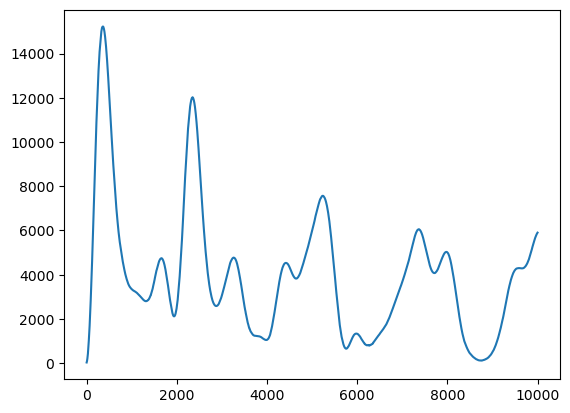

In [13]:
plt.plot(energy)

## Running the Kalman filter

In [27]:
P = P0 
P_pred = P0
x_kf = x0_kf
x_pred = x0_kf

all_states_kf = np.zeros((6,T+1))
all_states_kf[:,0] = x0_kf

energy_kf = np.zeros((T+1))
energy_kf[0] = 0.5 * (np.dot(x0_kf[3:6], x0_kf[3:6]) - np.dot(x0_kf[0:3], Kc @ x0_kf[0:3]))

current_timestep = dt
for j in np.arange(1,T+1):
    
    x_pred = A @ x_pred + B @ q_kf(current_timestep)
    P_pred = A @ P_pred @ A.T + Gamma @ Q @ Gamma.T
    
    # check if there's data at current timestep
    if j in data_steps:

        # determine Kalman gain matrix and 
        # incorporate data 
        
        K = P_pred @ E.T @ np.linalg.inv(E @ P @ E.T + R)
        x_kf = x_pred + K @ (data[:,j] - E @ x_kf)
        P = P_pred - K @ E @ P_pred
        
        all_states_kf[:, j] = x_kf

    else:
        
        x_kf = x_pred 
        P = P_pred

    # store states and energy
    all_states_kf[:, j] = x_kf
    energy_kf[j] = 0.5 * (np.dot(x_kf[3:6], x_kf[3:6]) - np.dot(x_kf[0:3], Kc @ x_kf[0:3]))

    # cycle states and uncertainty
    x_pred = x_kf
    P_pred = P

    # step forward
    current_timestep += dt 


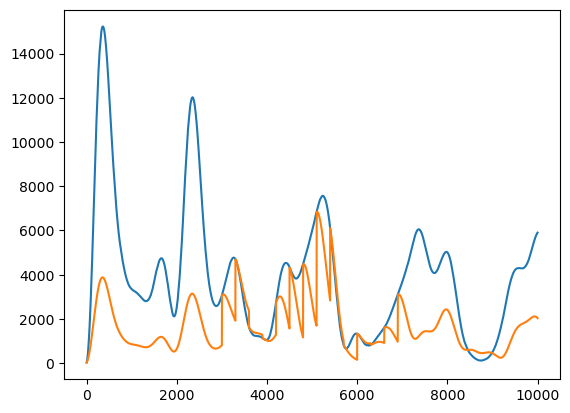

In [30]:
plt.plot(energy)
plt.plot(energy_kf)

In [97]:
a = np.array([1,2,3,4,5,6])

In [98]:
a[0:3]

array([1, 2, 3])

In [100]:
a[3:6]

array([4, 5, 6])